In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)


2.11.0


In [2]:
train_df=pd.read_csv('train.csv').fillna(' ')
test_df=pd.read_csv('test.csv').fillna(' ')
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [3]:
x=train_df['comment_text'].values
x

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

In [4]:
y = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [5]:
max_features=20000
max_text_length=400

In [6]:
x_tokenizer=text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized=x_tokenizer.texts_to_sequences(x)
x_train_val=sequence.pad_sequences(x_tokenized,maxlen=max_text_length)

In [7]:
x_train_val

array([[    0,     0,     0, ...,  4583,  2273,   985],
       [    0,     0,     0, ...,   589,  8377,   182],
       [    0,     0,     0, ...,     1,   737,   468],
       ...,
       [    0,     0,     0, ...,  3509, 13675,  4528],
       [    0,     0,     0, ...,   151,    34,    11],
       [    0,     0,     0, ...,  1627,  2056,    88]])

In [8]:
embedding_dim=100
embedding_index=dict()
f=open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32') 
    embedding_index[word]=coefs
    
f.close()
print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [9]:
embedding_matrix=np.zeros((max_features,embedding_dim))
for word,index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]=embedding_vector

In [10]:
model_multi_label = Sequential()
model_multi_label.add(Embedding(max_features,
                                embedding_dim,
                                embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                input_length=max_text_length,
                                trainable=False))
model_multi_label.add(Dropout(0.2))
filters = 250
kernel_size = 3
hidden_dims=250
model_multi_label.add(Conv1D(filters,
                             kernel_size,
                             padding='valid',
                             activation='relu'))
model_multi_label.add(MaxPooling1D())
model_multi_label.add(Conv1D(filters,
                             5,
                             padding='valid',
                             activation='relu'))
model_multi_label.add(GlobalMaxPooling1D())
model_multi_label.add(Dense(hidden_dims, activation='relu'))
model_multi_label.add(Dropout(0.2))

model_multi_label.add(Dense(6, activation='sigmoid'))
model_multi_label.summary()


model_multi_label.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          2000000   
                                                                 
 dropout (Dropout)           (None, 400, 100)          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 250)          75250     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 250)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 250)          312750    
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                         

In [11]:

model_multi_label.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])  


x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size=0.2, random_state=1)

#Training the model
batch_size = 32
epochs = 3
model_multi_label.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))


Epoch 1/3
3990/3990 [==============================] - 356s 89ms/step - loss: 0.0660 - binary_accuracy: 0.9774 - val_loss: 0.0544 - val_binary_accuracy: 0.9805
Epoch 2/3
3990/3990 [==============================] - 334s 84ms/step - loss: 0.0545 - binary_accuracy: 0.9803 - val_loss: 0.0659 - val_binary_accuracy: 0.9792
Epoch 3/3
3990/3990 [==============================] - 339s 85ms/step - loss: 0.0505 - binary_accuracy: 0.9815 - val_loss: 0.0506 - val_binary_accuracy: 0.9814


In [26]:

input_text = "Fuck around and find out"

# Tokenize the input text
text_sequence = x_tokenizer.texts_to_sequences([input_text])
# Pad sequences
text_sequence_padded = sequence.pad_sequences(text_sequence, maxlen=max_text_length)
# Make prediction
prediction = model_multi_label.predict(text_sequence_padded)
threshold = 0.5
toxicity_labels = (prediction > threshold).astype(int)


print(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
print("Predicted Labels:", toxicity_labels[0])

1/1 [==============================] - 0s 20ms/step
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Predicted Labels: [1 0 1 0 0 0]


In [23]:
model_multi_label.save("multi_label_model.h5")

In [16]:
import pickle

# Assuming x_tokenizer is your tokenizer object
with open('multilabel_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# import pickle

# # Load tokenizer from file
# with open('multilabel_tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
import pickle

try:
    with open('multilabel_tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
except FileNotFoundError:
    print("Tokenizer file not found. Please ensure the file exists in the specified location.")
except (pickle.PickleError, EOFError) as e:
    print("Error loading tokenizer:", e)

In [18]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("multi_label_model.h5")

In [25]:

input_text = ""

text_sequence = tokenizer.texts_to_sequences([input_text])
#padding input to max length
from tensorflow.keras.preprocessing import text, sequence
max_text_length=400
text_sequence_padded = sequence.pad_sequences(text_sequence, maxlen=max_text_length)
#making prediction
prediction = loaded_model.predict(text_sequence_padded)

threshold = 0.5
print(prediction)
toxicity_labels = (prediction > threshold).astype(int)

# Print the predicted labels
print(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
print("Predicted Labels:", toxicity_labels[0])

1/1 [==============================] - 0s 37ms/step
[[0.3288826  0.00169114 0.05497004 0.01256188 0.11221161 0.01839871]]
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Predicted Labels: [0 0 0 0 0 0]


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions on validation data
y_pred = model_multi_label.predict(x_val)

#setting threashold for binary
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate precision, recall, and F1 score for each label
precision = precision_score(y_val, y_pred_binary, average='weighted', zero_division=0)
recall = recall_score(y_val, y_pred_binary, average='weighted', zero_division=0)
f1 = f1_score(y_val, y_pred_binary, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


998/998 [==============================] - 19s 19ms/step
Precision: 0.7890545157619616
Recall: 0.6698327190246669
F1 Score: 0.7148425677535549


In [13]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val.flatten(), y_pred_binary.flatten())

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[183210   1226]
 [  2329   4725]]


In [14]:
from sklearn.metrics import accuracy_score

# Compute accuracy
accuracy = accuracy_score(y_val.flatten(), y_pred_binary.flatten())

print("Accuracy:", accuracy)

Accuracy: 0.981435061883127


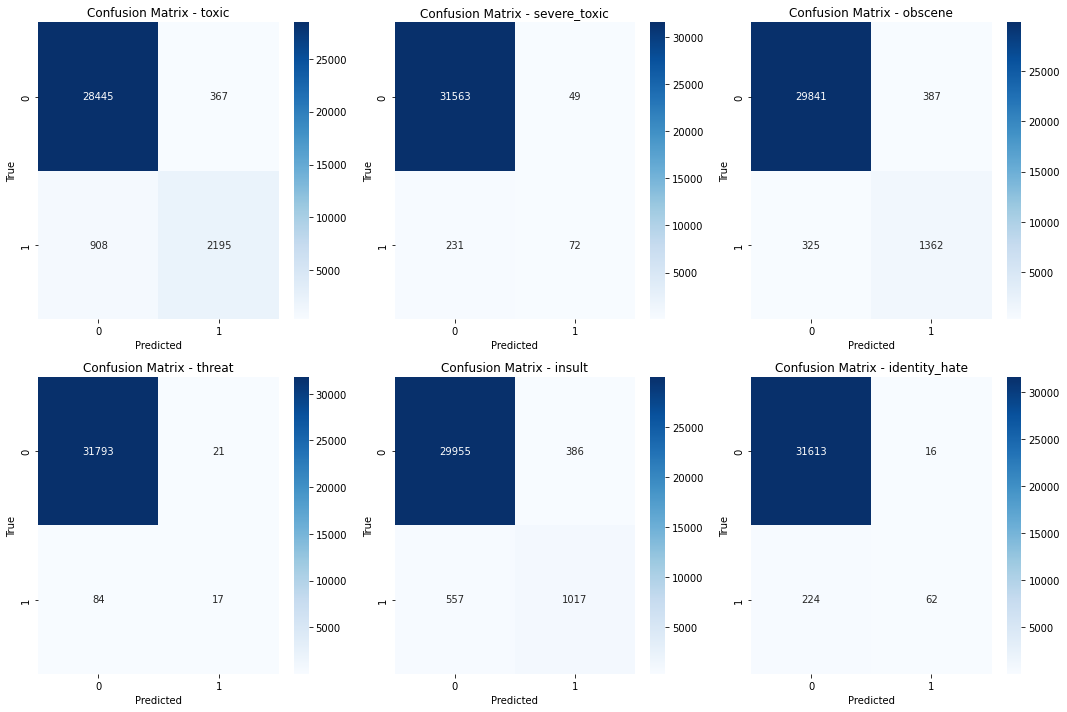

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Compute the confusion matrix
conf_matrix = multilabel_confusion_matrix(y_val, y_pred_binary)

# Plot the confusion matrix
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, (label, ax) in enumerate(zip(labels, axes.flatten())):
    sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {label}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()